In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
#%matplotlib inline
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
# Definir nuestro sistema.
f=5.
dt=0.05
dt2 = dt*dt
g=9.8
Zd = 100
A = np.array([[1,0,dt,0,0],[0,1,0,dt,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]], dtype=float) #"Matriz" de transicion de estado.
B = np.array([0,dt2,0,2*dt,0], dtype=float).transpose() #"Matriz" de control.
H = np.array([[1000/Zd,0,0,0,960],[0,1000/Zd,0,0,540]], dtype=float) #"Matriz" de medición.
P = 1*np.eye(5, dtype=float) #"Matriz" de incertidumbre del estado.
Q = 1e-9*np.eye(5, dtype=float) #"Matriz" de incertidumbre de la predicción.
R = 1*np.eye(2, dtype=float) #"Matriz" de incertidumbre de la medición.
P[4,4]=0

Kk = np.array([[1000,0,960],[0,1000,540],[0,0,1]],dtype=float)
Uc = -g/2

<IPython.core.display.Javascript object>


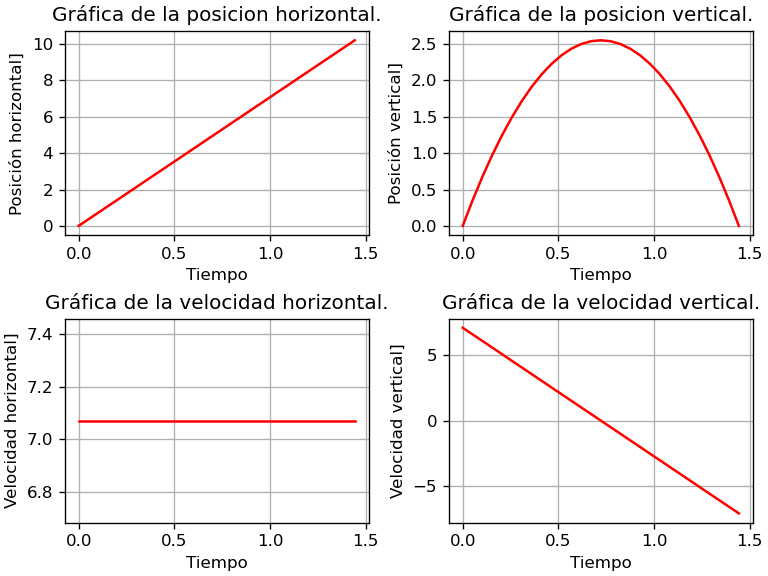

In [3]:
#Generar datos ideales del tiro parabolico.

xo = yo = 0
theta = 45 * np.pi/180
vo = 10
vox = vo * np.cos(theta)
voy = vo * np.sin(theta)
Tfinal = 1 * (2*voy/g)

#Aqui hay que terminar de desarrollar el sistema para generar las mediciones y añadirles ruido
# Z= ...
# Número de mediciones
N = int(np.ceil(Tfinal / dt))

t = np.linspace(0, Tfinal, N)

# Posición en función del tiempo
X = vox * t
Y = voy * t - 0.5 * g * t**2
VX = vox * np.ones(t.shape)
VY = voy - g * t


Z = Zd * np.ones(N)

#Vector de posiciones
P=np.array([X,Y,Z])

fig0, (ax0, ax1) = plt.subplots(2, 2, layout='constrained')

ax0[0].plot(t, X,'r', label='Posición horizontal.')
ax0[0].set(xlabel='Tiempo', ylabel='Posición horizontal]',
       title='Gráfica de la posicion horizontal.')
ax0[0].grid()

ax0[1].plot(t, Y,'r', label='posición vertical.')
ax0[1].set(xlabel='Tiempo', ylabel='Posición vertical]',
       title='Gráfica de la posicion vertical.')
ax0[1].grid()

ax1[0].plot(t, VX, 'r', label='Velocidad horizontal.')
ax1[0].set(xlabel='Tiempo', ylabel='Velocidad horizontal]',
       title='Gráfica de la velocidad horizontal.')
ax1[0].grid()

ax1[1].plot(t, VY,'r', label='Velocidad vertical.')
ax1[1].set(xlabel='Tiempo', ylabel='Velocidad vertical]',
       title='Gráfica de la velocidad vertical.')
ax1[1].grid()



(3, 29)


<IPython.core.display.Javascript object>


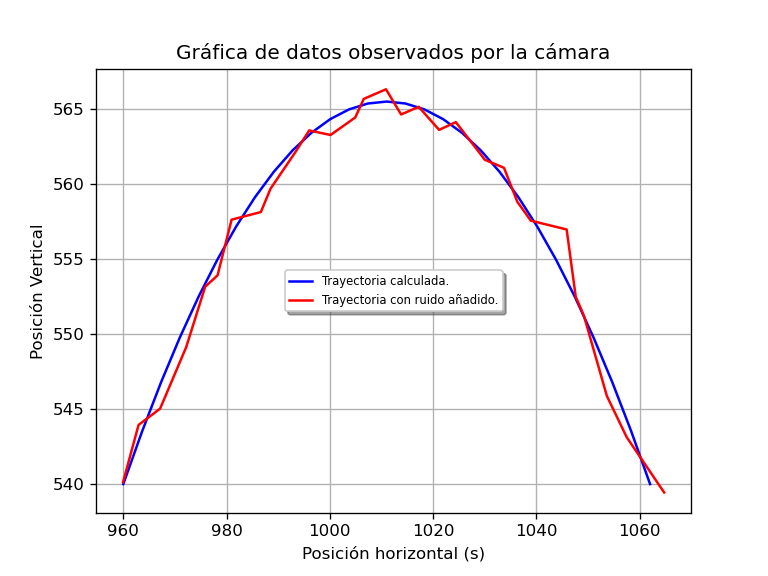

In [4]:
K=np.array([[1000,0, 960],[0,1000,540],[0,0,1]])
p = np.dot(K, P)
print (p.shape)
x=np.zeros(N)
y=np.zeros(N)
for i in range(N):
  x[i] = p[0,i]/p[2,i]
  y[i] = p[1,i]/p[2,i]
#Convertimos a coordenadas cartesianas
#Le añadimos ruido a las mediciones.
xn = x + rnd.randn(N) * np.sqrt(R[0,0])
yn = y + rnd.randn(N) * np.sqrt(R[1,1])

# Graficamos los datos del sensor (Cámara)
fig1, ax1 = plt.subplots()
plt.plot(x, y, 'b', label='Trayectoria calculada.')
plt.plot(xn, yn, 'r', label='Trayectoria con ruido añadido.')
ax1.set(xlabel='Posición horizontal (s)', ylabel='Posición Vertical',
       title='Gráfica de datos observados por la cámara')
legend1 = ax1.legend(loc='center', shadow=True, fontsize='x-small')
ax1.grid()


In [5]:
# $\hat{x}_{k-1}$ => xhat_k0
# $\hat{x}_{k}$ => xhat_k1
# $\bar{x}_{k}$ => xbar_k1

def KalmanFilter (Xhat_k0, Phat_k0, U_k1, Z_k, A, B, H, Q, R):
    #Predicción
    Xbar_k1 = np.dot(A, Xhat_k0) + np.dot(B, U_k1)
    Pbar_k1 = np.dot(A, np.dot(Phat_k0, A.transpose()))+Q
    
    #Actualización

    #Calculamos la ganancia.
    denom = np.dot(np.dot(H, Pbar_k1), H.transpose())+R
    if len(denom) > 1:
        denom = la.inv(denom)
    else:
        denom = 1. / denom
    Kgain = np.dot(np.dot(Pbar_k1, H.transpose()),denom)

    # Actualizamos el Estado y su incertidumbre.
    Xhat_k1 = Xbar_k1 + np.dot(Kgain, (Z_k- np.dot(H, Xbar_k1)))
    Phat_k1 = np.dot(np.eye(len(Xhat_k0))-np.dot(Kgain,H), Pbar_k1)
    
    return Xhat_k1, Phat_k1, Xbar_k1

In [6]:
#definimos un valor inicial y su incertidumbre estimada (Mat. Cov).

print(x.shape,yn.shape)
Vn = np.vstack([xn,yn])
print(Vn.shape,Vn[0,0],Vn[1,0])



x0 = np.array([(Vn[0,0]-960)*Zd/1000,(Vn[1,0]-540)*Zd/1000/Zd,vox,voy,1])
P0 = np.array([0.1], dtype=float)

#Definimos matrices para almacenar la evolucion del sistema.
Xhat=np.zeros((5, N))
Xbar=np.zeros((5, N))
Phat=np.zeros((5,5,N))
trP=np.zeros(N)

#Inicializamos valor 0 de la estimacion del estado y su incertidumbre (Mat. Cov)
Xhat[:,0], Phat[:,:,0] = x0, P0

for idx in range(1,N):
    Z = Vn[:,idx] #Obtenemos una medicion.

    Xhat[:, idx], Phat[:,:,idx], Xbar[:, idx] = KalmanFilter (Xhat[:,idx-1], Phat[:,:,idx-1], Uc, Z, A, B, H, Q, R)
    Xhat[4,idx] = 1
    trP[idx-1]= np.sum(np.sqrt(np.diag(Phat[:4,:4,idx])))

Xbar[:,0] = Xbar[:,1]

(29,) (29,)
(2, 29) 959.952243154882 540.1256949794263


<IPython.core.display.Javascript object>


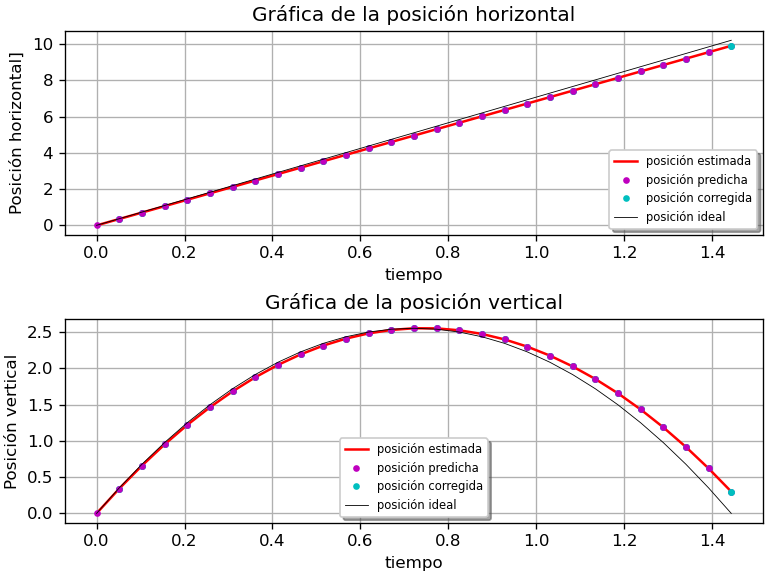

In [7]:
#Graficamos la Posicion.
fig2, (ax21, ax22) = plt.subplots(2, 1, layout='constrained')
i=1

ax21.plot((t[i-1],t[i]),(Xhat[0,i-1],Xhat[0,i]),'r', label='posición estimada')
ax21.plot((t[i-1],t[i]),(Xhat[0,i-1],Xbar[0,i]),'m.', label='posición predicha')
ax21.plot((t[i],t[i]),(Xbar[0,i],Xhat[0,i]),'c.', label='posición corregida')
ax22.plot((t[i-1],t[i]),(Xhat[1,i-1],Xhat[1,i]),'r', label='posición estimada')
ax22.plot((t[i-1],t[i]),(Xhat[1,i-1],Xbar[1,i]),'m.', label='posición predicha')
ax22.plot((t[i],t[i]),(Xbar[1,i],Xhat[1,i]),'c.', label='posición corregida')
for i in range(2,N):
    ax21.plot((t[i-1],t[i]),(Xhat[0,i-1],Xhat[0,i]),'r')
    ax21.plot((t[i-1],t[i]),(Xhat[0,i-1],Xbar[0,i]),'m.')
    ax21.plot((t[i],t[i]),(Xbar[0,i],Xhat[0,i]),'c.')
    ax22.plot((t[i-1],t[i]),(Xhat[1,i-1],Xhat[1,i]),'r')
    ax22.plot((t[i-1],t[i]),(Xhat[1,i-1],Xbar[1,i]),'m.')
    ax22.plot((t[i],t[i]),(Xbar[1,i],Xhat[1,i]),'c.')
ax21.plot(t,X,'k', linewidth=0.5, label='posición ideal')
ax22.plot(t,Y,'k', linewidth=0.5, label='posición ideal')

ax21.set(xlabel='tiempo', ylabel='Posición horizontal]',
       title='Gráfica de la posición horizontal')
ax21.grid()
ax22.set(xlabel='tiempo', ylabel='Posición vertical',
       title='Gráfica de la posición vertical')
ax22.grid()

legend21 = ax21.legend(loc='lower right', shadow=True, fontsize='x-small')
legend21 = ax22.legend(loc='lower center', shadow=True, fontsize='x-small')


<IPython.core.display.Javascript object>


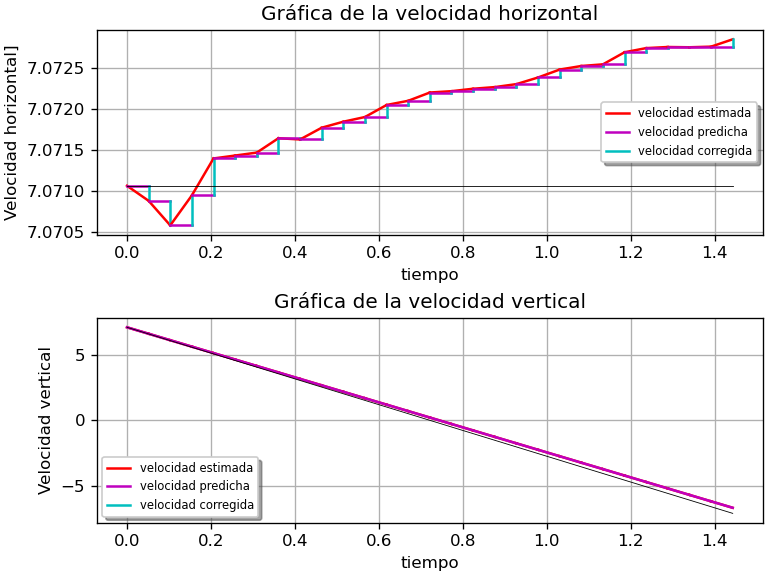

In [8]:
#Graficamos la Velocidad.
fig3, (ax31, ax32) = plt.subplots(2, 1, layout='constrained')
i=1

ax31.plot((t[i-1],t[i]),(Xhat[2,i-1],Xhat[2,i]),'r', label='velocidad estimada')
ax31.plot((t[i-1],t[i]),(Xhat[2,i-1],Xbar[2,i]),'m', label='velocidad predicha')
ax31.plot((t[i],t[i]),(Xbar[2,i],Xhat[2,i]),'c', label='velocidad corregida')
ax32.plot((t[i-1],t[i]),(Xhat[3,i-1],Xhat[3,i]),'r', label='velocidad estimada')
ax32.plot((t[i-1],t[i]),(Xhat[3,i-1],Xbar[3,i]),'m', label='velocidad predicha')
ax32.plot((t[i],t[i]),(Xbar[3,i],Xhat[3,i]),'c', label='velocidad corregida')
for i in range(2,N):
    ax31.plot((t[i-1],t[i]),(Xhat[2,i-1],Xhat[2,i]),'r')
    ax31.plot((t[i-1],t[i]),(Xhat[2,i-1],Xbar[2,i]),'m')
    ax31.plot((t[i],t[i]),(Xbar[2,i],Xhat[2,i]),'c')
    ax32.plot((t[i-1],t[i]),(Xhat[3,i-1],Xhat[3,i]),'r')
    ax32.plot((t[i-1],t[i]),(Xhat[3,i-1],Xbar[3,i]),'m')
    ax32.plot((t[i],t[i]),(Xbar[3,i],Xhat[3,i]),'c')
ax31.plot(t,VX,'k', linewidth=0.5)
ax32.plot(t,VY,'k', linewidth=0.5)

ax31.set(xlabel='tiempo', ylabel='Velocidad horizontal]',
       title='Gráfica de la velocidad horizontal')
ax31.grid()
ax32.set(xlabel='tiempo', ylabel='Velocidad vertical',
       title='Gráfica de la velocidad vertical')
ax32.grid()

legend21 = ax31.legend(loc='center right', shadow=True, fontsize='x-small')
legend21 = ax32.legend(loc='lower left', shadow=True, fontsize='x-small')


<IPython.core.display.Javascript object>


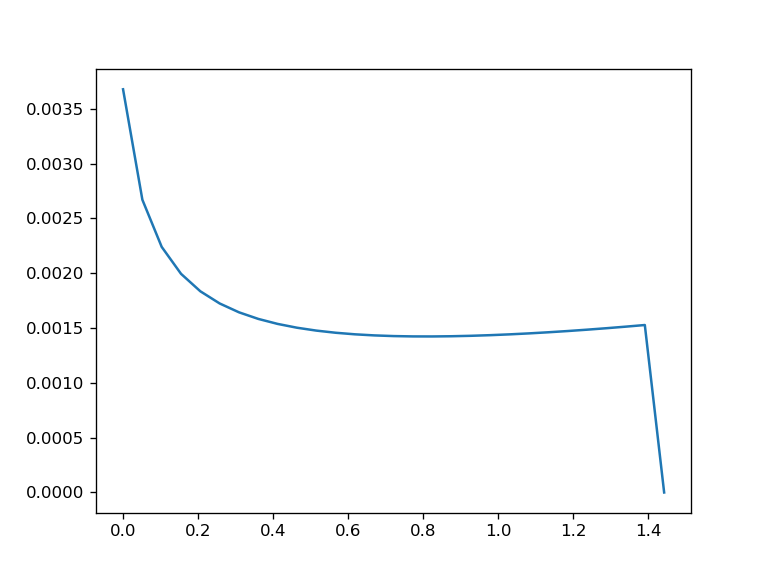

In [9]:
plt.figure(7)
plt.plot(t, trP)
